# **Project Computer Vision**
## **Image Classification**

In [1]:
%pip install kagglehub

import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import transforms as T

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict
import kagglehub

from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments

import evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Login onto Hugging Face hub to load any private dataset/model.
# We need to login as we'll also upload our model to the hub
notebook_login()

Token has not been saved to git credential helper.


## Load the dataset
---

In [29]:
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)


Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5


In [30]:
dataset = load_dataset("imagefolder", data_dir=path)

print(dataset)

Resolving data files:   0%|          | 0/5401 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})


#### The dataset contains the following features:
- image: the image stored in PIL format
- label: the ID of a folder in the dataset. the folder ist named with the species of the animal and contains corresponding images.

In [31]:
# Erstes Beispiel aus dem Trainingsdatensatz
example = dataset['train'][0]

# Zeige Inhalt
print(example)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1640x1025 at 0x7C15E01813C0>, 'label': 0}


In [32]:
# Alle eindeutigen Labels (z. B. IDs 0–89)
unique_labels = dataset['train'].unique('label')
print("Anzahl Klassen:", len(unique_labels))
print("Label-IDs:", unique_labels)

# Mapping von ID zu Tiernamen
label_names = dataset['train'].features['label'].names
print("Labelnamen:", label_names)


Anzahl Klassen: 90
Label-IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Labelnamen: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 

#### Some sample images of our dataset

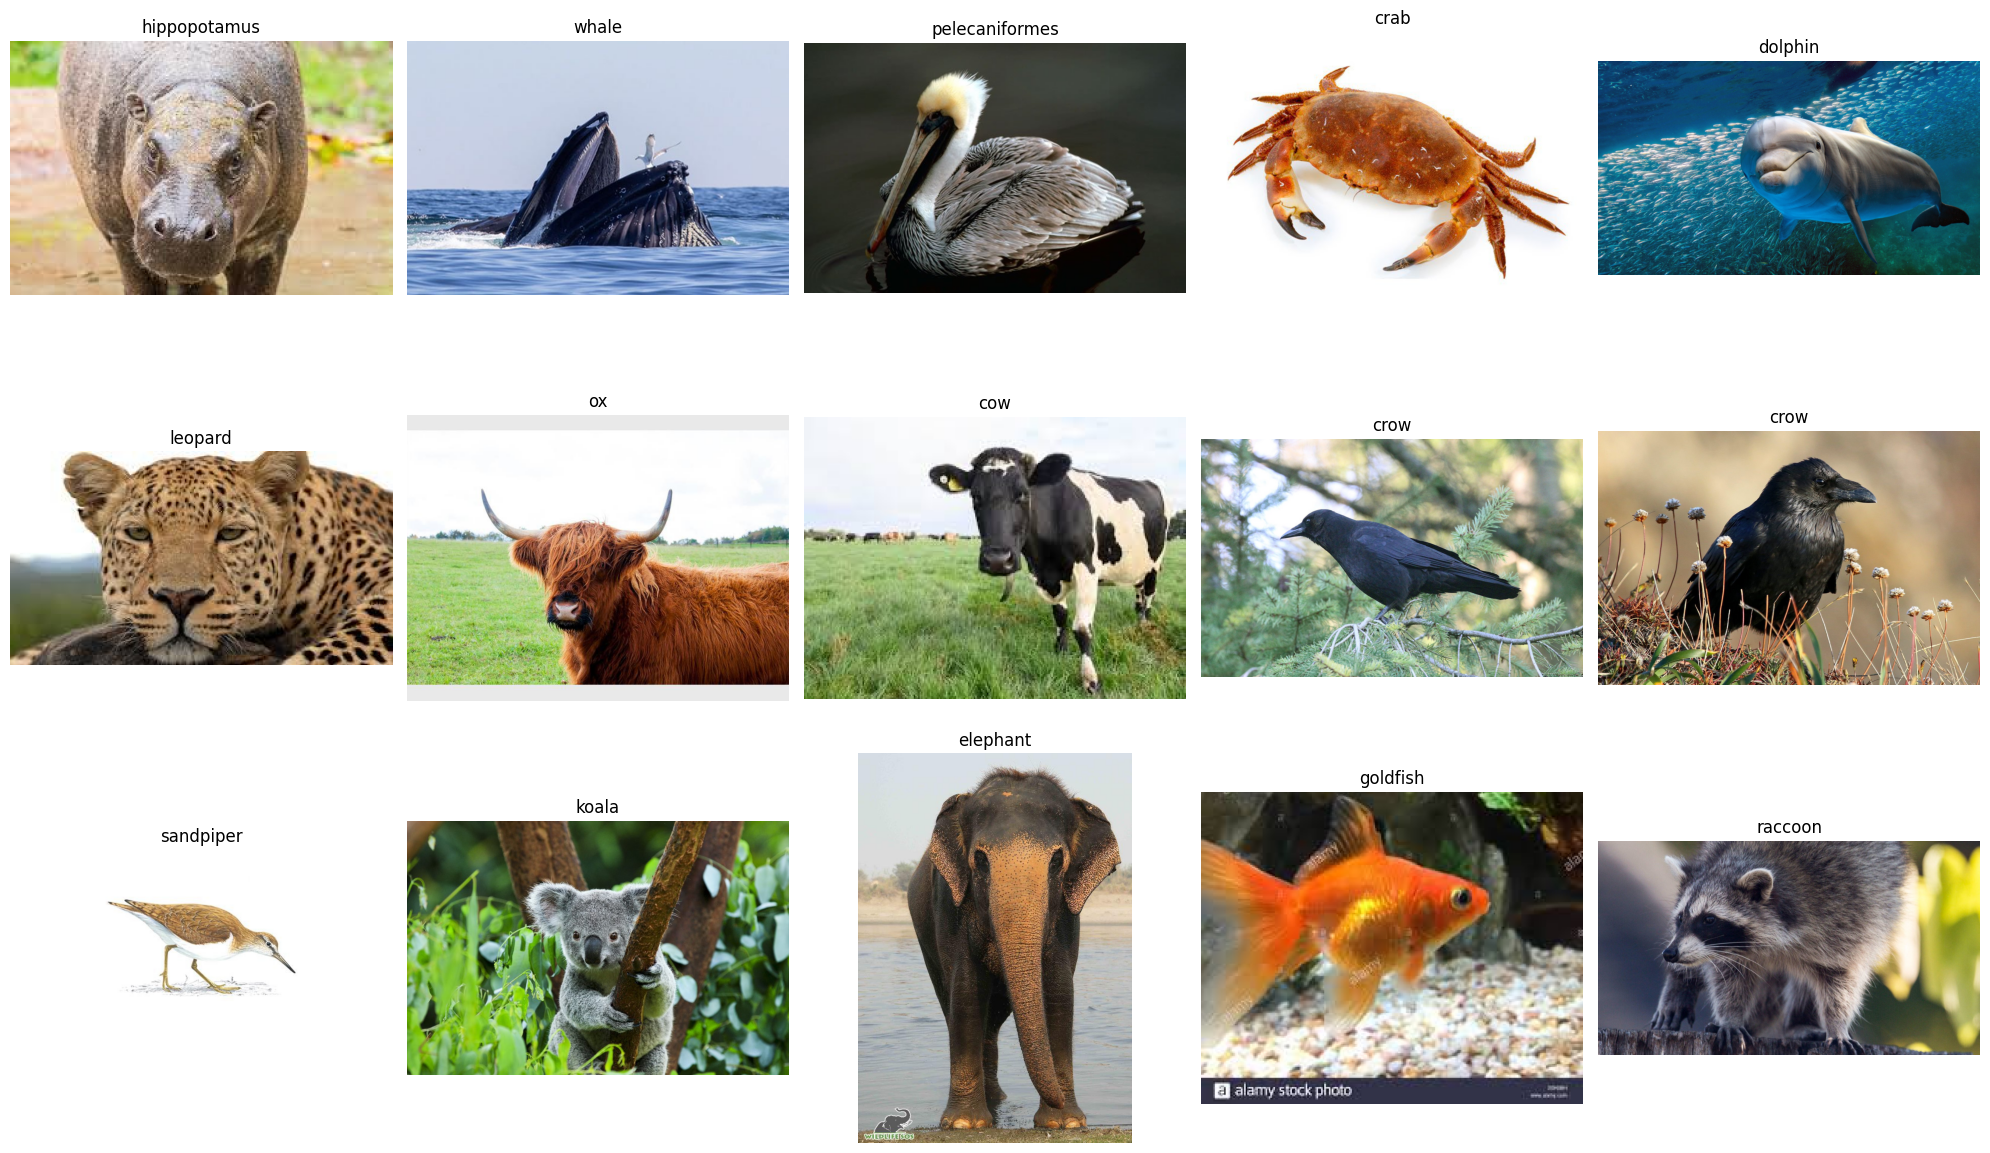

In [33]:
def show_samples(ds, rows, cols):
    samples = ds.shuffle(seed=42).select(np.arange(rows * cols))  # zufällige Auswahl
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    
    label_names = ds.features['label'].names  # ID → Klassenname

    for i in range(rows * cols):
        img = samples[i]['image']  # direkt als PIL-Bild
        label_id = samples[i]['label']
        label_name = label_names[label_id]

        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(label_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Beispielaufruf
show_samples(dataset['train'], rows=3, cols=5)

## Preprocessing the Dataset
---

In [34]:
from datasets import DatasetDict

split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5, seed=42)

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

print(our_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4320
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
})


#### Test for species in different sets

Because of the structure of the dataset, I want to check whether all 90 animal classes are represented across the train, validation, and test splits.

In [35]:
for split in ['train', 'validation', 'test']:
    labels_in_split = set(our_dataset[split]['label'])
    print(f"{split}: {len(labels_in_split)} Klassen")

train: 90 Klassen
validation: 89 Klassen
test: 90 Klassen


### Image Processor

In [36]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

#### Data Augmentation

In [37]:
train_augmentation = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

In [38]:
# Augmentierungs-Transform für das Training
def train_transforms(batch):
    augmented_images = [train_augmentation(img) for img in batch['image']]
    inputs = processor(images=augmented_images, return_tensors="pt")
    inputs['labels'] = batch['label']
    return inputs

# Transform-Funktion für Val/Test
def transforms(batch):
    inputs = processor(batch['image'], return_tensors="pt")
    inputs['labels'] = batch['label']
    return inputs

In [39]:
# Alle Splits bekommen die Standard-Transforms
processed_dataset = our_dataset.with_transform(transforms)

# Trainingssplit überschreiben mit Augmentierungstransforms
processed_dataset['train'] = processed_dataset['train'].with_transform(train_transforms)

In [40]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4320
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 540
    })
})

### Data collation

In [41]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Calculate the Metrics
---

In [42]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Loading the Model
---

In [43]:
label_names = our_dataset['train'].features['label'].names

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

In [44]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

#### Freeze the parameters

In [46]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

#### Check the number of total parameters and of trainable ones

In [47]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,867,866 | trainable_params = 69,210


## Training
---

In [48]:
training_args = TrainingArguments(
    output_dir="./vit-90-animals",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',  # ← Optional, wenn du TensorBoard nutzt
    load_best_model_at_end=True,
    run_name="vit-90-animals-transferlearning"
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

/tmp/ipykernel_2110/613752247.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [50]:
trainer.train()

TrainOutput(global_step=1350, training_loss=0.5378526609915274, metrics={'train_runtime': 2234.077, 'train_samples_per_second': 9.668, 'train_steps_per_second': 0.604, 'total_flos': 1.6751471500689408e+18, 'train_loss': 0.5378526609915274, 'epoch': 5.0})

#### Evaluating on the test dataset

In [55]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.08400189876556396,
 'eval_accuracy': 0.9796296296296296,
 'eval_runtime': 13.3237,
 'eval_samples_per_second': 40.529,
 'eval_steps_per_second': 5.104,
 'epoch': 5.0}

#### Some predictions made by the trained model

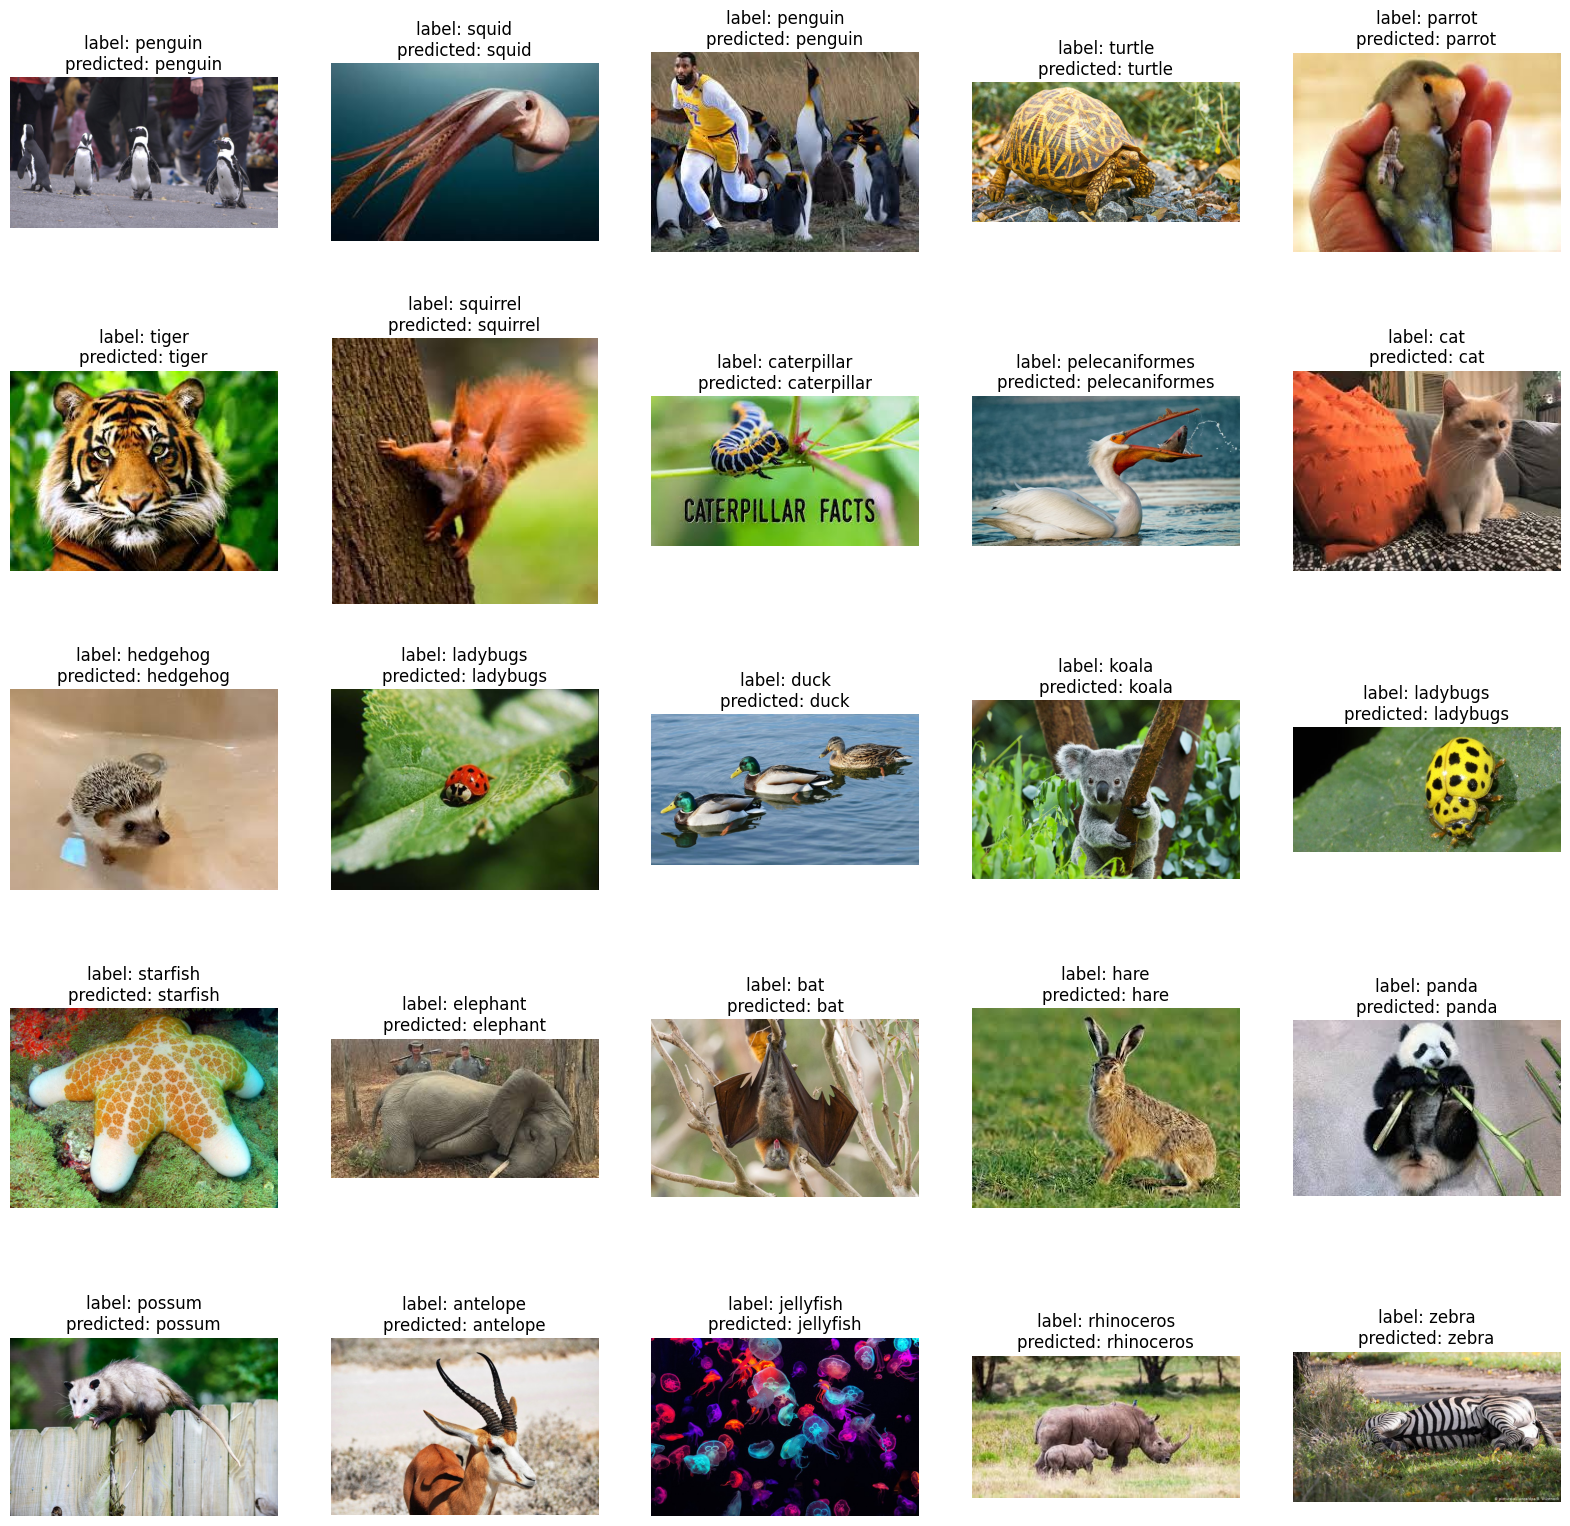

In [56]:
%matplotlib inline

def show_predictions(rows, cols):
    samples = our_dataset['test'].shuffle(seed=42).select(np.arange(rows * cols))

    processed_samples = samples.with_transform(transforms)

    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)

    fig = plt.figure(figsize=(cols * 4, rows * 4))
    label_names = our_dataset['train'].features['label'].names

    for i in range(rows * cols):
        img = samples[i]['image']
        true_label = label_names[samples[i]['label']]
        pred_label = label_names[predictions[i]]
        label = f"label: {true_label}\npredicted: {pred_label}"

        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)


## Save and push Model
---

In [53]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": "iamsouravbanerjee/animal-image-dataset-90-different-animals",
    "tasks": "image-classification",
    "tags": ["image-classification", "animals", "vision-transformer", "vit", "transfer-learning"],
}

In [54]:
trainer.save_model()
trainer.push_to_hub("vit-90-animals-da", **kwargs)

events.out.tfevents.1747494942.cs-01jvf84h4q9vae662f2w6rkkkt.2110.3:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/maceythm/vit-90-animals/commit/7538403f61b3d99a7738616308d17d48c88546ee', commit_message='vit-90-animals-da', commit_description='', oid='7538403f61b3d99a7738616308d17d48c88546ee', pr_url=None, repo_url=RepoUrl('https://huggingface.co/maceythm/vit-90-animals', endpoint='https://huggingface.co', repo_type='model', repo_id='maceythm/vit-90-animals'), pr_revision=None, pr_num=None)